In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
import functools as ft
import optax
import treex as tx
from sdf_jax import SimpleNeuralSDF, plot2d, print_callback

# Implicit Geometric Regularization

"Implicit Geometric Regularization for Learning Shapes"
Gropp et al. ICML 2020
https://arxiv.org/abs/2002.10099


![](igr_loss.png)

In [11]:
def surface_loss_fn(model, x):
    return jnp.abs(x)

def eikonal_loss_fn(model, x):
    return (jnp.linalg.norm(jax.grad(model)(x)) - 1.0)**2

@ft.partial(jax.value_and_grad, has_aux=True)
def loss_fn(params, model, xs, lam, key, *, n_samples=20):
    model = model.merge(params)
    surface_loss = jnp.mean(jax.vmap(ft.partial(surface_loss_fn, model))(xs))
    xs_eik = jrandom.normal(key, (n_samples, 2))
    eikonal_loss = jnp.mean(jax.vmap(ft.partial(eikonal_loss_fn, model))(xs_eik))
    return surface_loss + eikonal_loss, model

@jax.jit
def train_step(model, xs, lam, optimizer, key):
    params = model.filter(tx.Parameter)
    (loss, model), grads = loss_fn(params, model, xs, lam, key)
    new_params = optimizer.update(grads, params)
    model = model.merge(new_params)
    return loss, model, optimizer

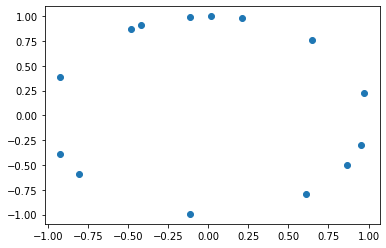

In [12]:
key = jax.random.PRNGKey(0)
key, theta_key = jrandom.split(key, 2)
theta = 2 * jnp.pi * jrandom.uniform(theta_key, (14,))
xs = jnp.vstack([jnp.cos(theta), jnp.sin(theta)]).T
plt.scatter(*xs.T)

(30, 2)
[0] loss: 0.8978
[10] loss: 0.6729
[20] loss: 0.6537
[30] loss: 0.6477
[40] loss: 0.6459
[50] loss: 0.6405
[60] loss: 0.6401
[70] loss: 0.6409
[80] loss: 0.6374
[90] loss: 0.6387


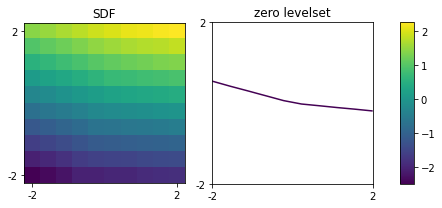

In [21]:
def fit(
    xs,
    # module
    dims=[50,50],
    act=jax.nn.relu,
    lam=1.0,
    # optimizer
    key=jrandom.PRNGKey(1234),
    lr=5e-3,
    steps=100,
    # utils
    cb=print_callback,
    cb_every=10,
):
    key, model_key = jrandom.split(key, 2)
    model = SimpleNeuralSDF(dims=dims, act=act).init(model_key, xs[0])
    optimizer = tx.Optimizer(optax.adam(lr))
    optimizer = optimizer.init(model.filter(tx.Parameter))
    for step in range(steps):
        key, step_key = jrandom.split(key, 2)
        loss, model, optimizer = train_step(model, xs, lam, optimizer, step_key)
        if step % cb_every == 0:
            cb(step, loss, model, optimizer)
    return loss, model

key = jax.random.PRNGKey(0)
key, theta_key = jrandom.split(key, 2)
theta = 2 * jnp.pi * jrandom.uniform(theta_key, (30,))
xs = jnp.vstack([jnp.cos(theta), jnp.sin(theta)]).T
print(xs.shape)
loss, model = fit(xs)
plot2d(model)

[0] loss: 0.8769
[10] loss: 0.6599
[20] loss: 0.6360
[30] loss: 0.6377
[40] loss: 0.6351
[50] loss: 0.6348
[60] loss: 0.6343
[70] loss: 0.6342
[80] loss: 0.6342
[90] loss: 0.6342


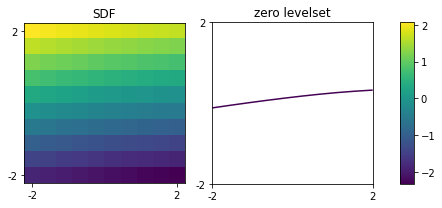

In [20]:
loss, model = fit(xs, act=jax.nn.softplus, lam=0.0)
plot2d(model)